In [ ]:
#https://plotly.com/python/visualizing-mri-volume-slices/

In [ ]:
#https://stackoverflow.com/questions/73726025/how-could-i-create-a-fps-1-mp4-video-using-ffmpegwriter-from-matplotlib-animatio

In [ ]:
#idea: extract LUT from Nikon elements viewer, take nd2 as numpy array. Plot frame by frame

In [ ]:
# maybe use instead of mpeg, gif: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

In [ ]:
# IMPORTANT: https://stackoverflow.com/questions/30965355/speedup-matplotlib-animation-to-video-file

In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [2]:
import h5py  # TODO: sometimes, importing from two_photon_session causes kernel to crash. In Anaconda prompt, mismatch of 
# h5py and hdf5:  h5py is running against HDF5 1.10.7 when it was built against 1.10.6,
from labrotation.two_photon_session import nb_view_patches_with_lfp_movement, TwoPhotonSession

In [3]:
import labrotation.file_handling as fh
#from labrotation.two_photon_session import TwoPhotonSession as TPS
from nd2_to_caiman import np_arr_from_nd2, np_arr_and_time_stamps_from_nd2
import numpy as np
import matplotlib.pylab as plt
import matplotlib.animation as animation
import subprocess
import csv
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import pyplot
import os

# Play two videos in parallel, below them time series with sliding vertical bar matching current frame of videos

In [ ]:
ts_left_fname = fh.open_file("Open data for left time series plot")
ts_right_fname = fh.open_file("Open data for right time series plot")

In [ ]:
video_left = fh.open_file("Select nd2 file to put on left")
video_right = fh.open_file("Select nd2 file to put on right")

In [ ]:
frames_range_left = [8400, 9400]  # first and last frames (1-indexing) to be read
frames_range_right = [8400, 9400]
print(frames_range_left[1] - frames_range_left[0] + 1)
print(frames_range_right[1] - frames_range_right[0] + 1)

In [ ]:
ndarr_left, tstamps_left = np_arr_and_time_stamps_from_nd2(video_left, frames_range_left)
ndarr_right, tstamps_right = np_arr_and_time_stamps_from_nd2(video_right, frames_range_right)

In [ ]:
time_series_left = []
with open(ts_left_fname) as csvfile:
    r = csv.reader(csvfile, delimiter=' ')
    i_frame = 0
    for row in r:
        if i_frame in range(frames_range_left[0], frames_range_left[1]+1):
            time_series_left.append(float(row[0].replace(',', '.')))
        i_frame += 1
    
    
time_series_right = []
with open(ts_right_fname) as csvfile:
    r = csv.reader(csvfile, delimiter=' ')
    i_frame = 0
    for row in r:
        if i_frame in range(frames_range_right[0], frames_range_right[1]+1):
            time_series_right.append(float(row[0].replace(',', '.')))
        i_frame += 1
    

In [ ]:
# time_series_left = np.random.rand(len(ndarr_left))
# time_series_right = np.random.rand(len(ndarr_right))

In [ ]:
tstamps_left_zeroed_s = [(tstamps_left[i] - tstamps_left[0])/1000. for i in range(len(tstamps_left))]
tstamps_right_zeroed_s = [(tstamps_right[i] - tstamps_right[0])/1000. for i in range(len(tstamps_right))]

In [ ]:
min_ts_left = min(time_series_left)
min_ts_right = min(time_series_right)
time_series_left_zeroed = [time_series_left[i] - min_ts_left for i in range(len(time_series_left))]
time_series_right_zeroed = [time_series_right[i] - min_ts_right for i in range(len(time_series_right))]

# Adjust parameters for layout, test on single frame here

In [ ]:
i_frame = 10
fontprops = fm.FontProperties(size=18)
#set up the figure

# height ratios:
# https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
# update matplotlib, then height_ratios can be directly passed to subplots()!
fig, axs = plt.subplots(2, 2, figsize=(18,10), gridspec_kw={'height_ratios': [3, 1]}, sharey="row")
axs[0,0].axis('off')
axs[0,1].axis('off')
canvas_width, canvas_height = fig.canvas.get_width_height()

# 1.579 µm / pixel -> 100 µm = 63.33 pixels

scalebar1 = AnchoredSizeBar(axs[0,0].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

scalebar2 = AnchoredSizeBar(axs[0,1].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)


axs[0,0].add_artist(scalebar1)
axs[0,1].add_artist(scalebar2)

# First frame
fig_left = axs[0, 0].imshow(ndarr_left[i_frame], ) #cmap="Greens_r"
ts_left = axs[1,0].plot(tstamps_left_zeroed_s, time_series_left_zeroed)
vline_left = axs[1,0].axvline(x=tstamps_left_zeroed_s[i_frame], color="red")


fig_right = axs[0, 1].imshow(ndarr_right[i_frame], )  #cmap="Greens_r"
ts_right = axs[1,1].plot(tstamps_right_zeroed_s, time_series_right_zeroed)
vline_right = axs[1, 1].axvline(x=tstamps_right_zeroed_s[i_frame], color="red")


axs[0,1].set_title('AAV1.syn.Flex.GCaMP6s.WPRE.SV40\nAAV.CamKIIO.4.Cre SV40', y=1.0, pad=-42, color="white", fontsize=20)
axs[0,0].set_title('AAV1.syn.GCaMP6s.WPRE.SV40', y=1.0, pad=-20, color="white", fontsize=20)

axs[1,0].set_xlabel("Time (s)", fontsize=22)
axs[1,0].tick_params(axis='x', labelsize=20)

axs[1,1].set_xlabel("Time (s)", fontsize=22)
axs[1,1].tick_params(axis='x', labelsize=20)

axs[1,0].set_ylabel("100% df/f", fontsize=18)
axs[1,1].set_ylabel("100% df/f", fontsize=18)
#axs[1,0].tick_params(axis='y', labelsize=20)

#axs[1,0].get_yaxis().set_visible(False)
#axs[1,1].get_yaxis().set_visible(False)
axs[1,0].get_yaxis().set_ticks([])
axs[1,1].get_yaxis().set_ticks([])
axs[1,0].spines['left'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)
axs[1,0].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                              clip_on=False,linewidth = 0))
axs[1,1].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                              clip_on=False,linewidth = 0))

#plt.tight_layout()
plt.show()

# Set up parameters and function for video export

In [ ]:
def testSubprocess():
    fontprops = fm.FontProperties(size=18)
    
    #set up the figure
    fig, axs = plt.subplots(2, 2, figsize=(18,16), gridspec_kw={'height_ratios': [3, 1]}, sharey="row")
    axs[0,0].axis('off')
    axs[0,1].axis('off')
    canvas_width, canvas_height = fig.canvas.get_width_height()

    
    scalebar1 = AnchoredSizeBar(axs[0,0].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

    scalebar2 = AnchoredSizeBar(axs[0,1].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
    
    axs[0,0].add_artist(scalebar1)
    axs[0,1].add_artist(scalebar2)
    
    # First frame
    fig_left = axs[0, 0].imshow(ndarr_left[0], ) # cmap="Greens_r"
    ts_left = axs[1,0].plot(tstamps_left_zeroed_s, time_series_left_zeroed)
    vline_left = axs[1,0].axvline(x=tstamps_left_zeroed_s[0], color="red")
    
    
    fig_right = axs[0, 1].imshow(ndarr_right[0], ) # cmap="Greens_r"
    ts_right = axs[1,1].plot(tstamps_right_zeroed_s, time_series_right_zeroed)
    vline_right = axs[1, 1].axvline(x=tstamps_right_zeroed_s[0], color="red")

    axs[0,1].set_title('AAV1.syn.Flex.GCaMP6s.WPRE.SV40\nAAV.CamKIIO.4.Cre SV40', y=1.0, pad=-42, color="white", fontsize=20)
    axs[0,0].set_title('AAV1.syn.GCaMP6s.WPRE.SV40', y=1.0, pad=-20, color="white", fontsize=20)

    axs[1,0].set_xlabel("Time (s)", fontsize=22)
    axs[1,0].tick_params(axis='x', labelsize=20)

    axs[1,1].set_xlabel("Time (s)", fontsize=22)
    axs[1,1].tick_params(axis='x', labelsize=20)

    axs[1,0].set_ylabel("100% df/f", fontsize=18)
    axs[1,1].set_ylabel("100% df/f", fontsize=18)
    #axs[1,0].tick_params(axis='y', labelsize=20)

    #axs[1,0].get_yaxis().set_visible(False)
    #axs[1,1].get_yaxis().set_visible(False)
    axs[1,0].get_yaxis().set_ticks([])
    axs[1,1].get_yaxis().set_ticks([])
    axs[1,0].spines['left'].set_visible(False)
    axs[1,0].spines['right'].set_visible(False)
    axs[1,0].spines['top'].set_visible(False)
    axs[1,1].spines['left'].set_visible(False)
    axs[1,1].spines['right'].set_visible(False)
    axs[1,1].spines['top'].set_visible(False)
    axs[1,0].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                                  clip_on=False,linewidth = 0))
    axs[1,1].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                                  clip_on=False,linewidth = 0))
    

    def update(frame):
        # your matplotlib code goes here
        fig_left.set_data(ndarr_left[frame])
        fig_right.set_data(ndarr_right[frame])
        vline_left.set_data([tstamps_left_zeroed_s[frame], tstamps_left_zeroed_s[frame]], [0, 1])
        vline_right.set_data([tstamps_right_zeroed_s[frame], tstamps_right_zeroed_s[frame]], [0, 1])

    # Open an ffmpeg process
    outf = "D:\\PhD\\Data\\testvid\\" + fh.get_filename_with_date("test_fast", ".mp4")
    print(outf)
    # lossless encoding:
    # https://stackoverflow.com/questions/37344997/how-to-get-a-lossless-encoding-with-ffmpeg-libx265
    cmdstring = ('ffmpeg', 
                 '-y', '-r', '15', # overwrite, 1fps
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 #'-vcodec', 'mpeg4', outf) # use mpeg4 encoding
                 '-c:v', 'libx265',
                 '-x265-params', '"profile=monochrome12:crf=0:lossless=1:preset=veryslow:qp=0"',
                 outf)
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(min(len(time_series_left), len(time_series_right))):
        print(frame)
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()
        
        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

In [ ]:
testSubprocess()

# Play Nikon recording, sliding bar of mean fluorescence, lfp, movement

In [4]:
matlab_2p_folder = fh.open_dir("Open matlab-2p folder")

In [5]:
# TODO: switch to UUID
nd2_fpath = fh.open_file("Open nd2 file")
nd2_timestamps_fpath = fh.open_file("Open Nikon time stamp file")
labview_fpath = fh.open_file("Open labview file")
labview_timestamps_fpath = os.path.splitext(labview_fpath)[0] + "time.txt"
lfp_fpath = fh.open_file("Open LFP file")

In [10]:
print(nd2_fpath)
print(nd2_timestamps_fpath)
print(labview_fpath)
print(labview_timestamps_fpath)
print(lfp_fpath)

Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_12_02\T386_ChR2_LR_elec_d6_20211202_488nm_500msec_002.nd2
Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_12_02\T386.021221.1201_nik.txt
Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_12_02\T386.021221.1201.txt
Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_12_02\T386.021221.1201time.txt
Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_12_02\21d02001.abf


In [13]:
tps = TwoPhotonSession.init_and_process(nd2_fpath, nd2_timestamps_fpath, labview_fpath, labview_timestamps_fpath, lfp_fpath, matlab_2p_folder)

Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_12_02
	T386.021221.1201
	T386.021221.1201_nik
Difference of starting times (s): 4.217992


In [14]:
fluor = tps.return_nikon_mean()

In [25]:
t = tps.belt_dict["time"]
t_fluor = tps.belt_dict["tsscn"]
loco = tps.belt_dict["speed"]

In [23]:
len(loco)

69267

In [27]:
len(fluor)

13483

In [28]:
t_fluor[:10]

array([  0.   ,  65.628, 131.255, ..., 459.373, 524.99 , 590.617])

In [22]:
t_lfp, y_lfp = tps.lfp_lfp()

In [38]:
nik = tps.get_nikon_data()

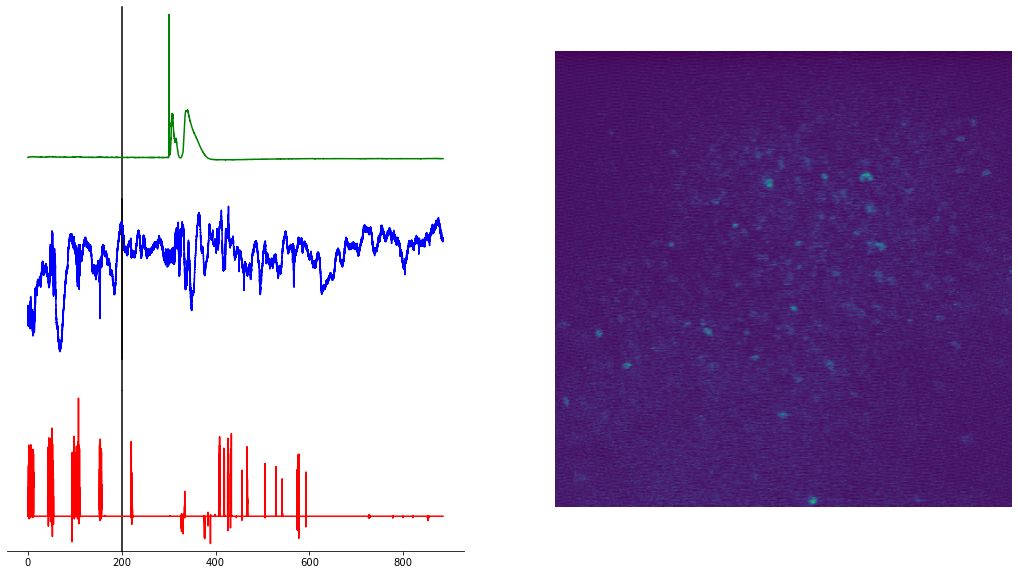

In [98]:
# Layout:
# left top figure: average luminosity
# Left middle: LFP
# left bottom: locomotion 
# Right: nd2 video playing

i_frame = 10
fontprops = fm.FontProperties(size=18)
#set up the figure

# height ratios:
# https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
# update matplotlib, then height_ratios can be directly passed to subplots()!
#fig, axs = plt.subplots(3, 2, figsize=(18,10), gridspec_kw={'height_ratios': [3, 1]}, sharey="row")
#fig, axs = plt.subplots(3, 2, figsize=(18,10), sharey="row")
#axs[0,0].axis('off')
#axs[0,1].axis('off')
#canvas_width, canvas_height = fig.canvas.get_width_height()

# 1.579 µm / pixel -> 100 µm = 63.33 pixels
"""
scalebar1 = AnchoredSizeBar(axs[0,0].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

scalebar2 = AnchoredSizeBar(axs[0,1].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)


axs[0,0].add_artist(scalebar1)
axs[0,1].add_artist(scalebar2)
"""
# Fill first frame
#fig_right = axs[0, 1].imshow(ndarr_right[i_frame], )  #cmap="Greens_r"
#ts_right = axs[1,1].plot(tstamps_right_zeroed_s, time_series_right_zeroed)
#vline_right = axs[1, 1].axvline(x=tstamps_right_zeroed_s[i_frame], color="red")

#fluor_plot = axs[0,0].plot(t_fluor, fluor)
#loco_plot = axs[1,0].plot(t, loco)
#lfp_plot = axs[2, 0].plot(t_lfp, y_lfp)

t_vertline = 200.0

fig = plt.figure(figsize=(18,10))
canvas_width, canvas_height = fig.canvas.get_width_height()
gridspec = fig.add_gridspec(3, 2)
ax_fluor = fig.add_subplot(gridspec[0,0])
ax_lfp =  fig.add_subplot(gridspec[1,0])
ax_loco = fig.add_subplot(gridspec[2,0])
ax_nikon = fig.add_subplot(gridspec[:, 1])

ax_fluor.plot(t_fluor/1000., fluor, color="green")
ax_lfp.plot(t_lfp, y_lfp, color="blue")
ax_loco.plot(t/1000., loco, color="red")

fig_nikon = ax_nikon.imshow(nik[0])

vline_fluor = ax_fluor.axvline(x=t_vertline, ymin=-1.2, ymax=1, zorder=0,clip_on=False, color="black")
vline_lfp = ax_lfp.axvline(x=t_vertline, ymin=-1.2, ymax=1, zorder=0,clip_on=False, color="black")
vline_loco = ax_loco.axvline(x=t_vertline, zorder=0,clip_on=False, color="black")

fig_nikon.set_data(nik[100])

ax_nikon.axis('off')
ax_fluor.axis('off')
ax_lfp.axis('off')
ax_loco.spines['left'].set_visible(False)
ax_loco.spines['right'].set_visible(False)
ax_loco.spines['top'].set_visible(False)
ax_loco.get_yaxis().set_ticks([])
#ax_fluor.get_yaxis().set_visible(False)
#ax_lfp.get_yaxis().set_visible(False)
#ax_loco.get_yaxis().set_visible(False)

#ax_fluor.get_xaxis().set_visible(False)
#ax_lfp.get_xaxis().set_visible(False)

plt.show()

In [100]:
def saveVid(i_frame_begin, i_frame_end):  # in 1-indexing
    t_vertline = t_fluor[i_frame_begin - 1]
    
    fig = plt.figure(figsize=(18,10))
    canvas_width, canvas_height = fig.canvas.get_width_height()
    gridspec = fig.add_gridspec(3, 2)
    ax_fluor = fig.add_subplot(gridspec[0,0])
    ax_lfp =  fig.add_subplot(gridspec[1,0])
    ax_loco = fig.add_subplot(gridspec[2,0])
    ax_nikon = fig.add_subplot(gridspec[:, 1])

    ax_fluor.plot(t_fluor/1000., fluor, color="green")
    ax_lfp.plot(t_lfp, y_lfp, color="blue")
    ax_loco.plot(t/1000., loco, color="red")

    ax_nikon.imshow(nik[0])

    vline_fluor = ax_fluor.axvline(x=t_vertline, ymin=-1.2, ymax=1, zorder=0,clip_on=False, color="black")
    vline_lfp = ax_lfp.axvline(x=t_vertline, ymin=-1.2, ymax=1, zorder=0,clip_on=False, color="black")
    vline_loco = ax_loco.axvline(x=t_vertline, zorder=0,clip_on=False, color="black")

    ax_nikon.axis('off')
    ax_fluor.axis('off')
    ax_lfp.axis('off')
    ax_loco.spines['left'].set_visible(False)
    ax_loco.spines['right'].set_visible(False)
    ax_loco.spines['top'].set_visible(False)
    ax_loco.get_yaxis().set_ticks([])
    
    def update(frame):
        # your matplotlib code goes here
        fig_nikon.set_data(nik[frame])

        vline_fluor.set_data([t_fluor[frame - 1], t_fluor[frame - 1]], [-1.2, 1])
        vline_lfp.set_data([t_fluor[frame - 1], t_fluor[frame - 1]], [-1.2, 1])
        vline_loco.set_data([t_fluor[frame - 1], t_fluor[frame - 1]], [0, 1])

    # Open an ffmpeg process
    outf = os.path.join(fh.open_dir("Choose output folder"), fh.get_filename_with_date("test_video", ".mp4"))
    print(outf)
    # lossless encoding:
    # https://stackoverflow.com/questions/37344997/how-to-get-a-lossless-encoding-with-ffmpeg-libx265
    cmdstring = ('ffmpeg', 
                 '-y', '-r', '15', # overwrite, 1fps
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 #'-vcodec', 'mpeg4', outf) # use mpeg4 encoding
                 '-c:v', 'libx265',
                 '-x265-params', '"profile=monochrome12:crf=0:lossless=1:preset=veryslow:qp=0"',
                 outf)
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE, shell=True)

    # Draw frames and write to the pipe
    for frame in range(i_frame_begin, i_frame_end+1):
        print(frame)
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()
        print(string)
        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



OSError: [Errno 22] Invalid argument

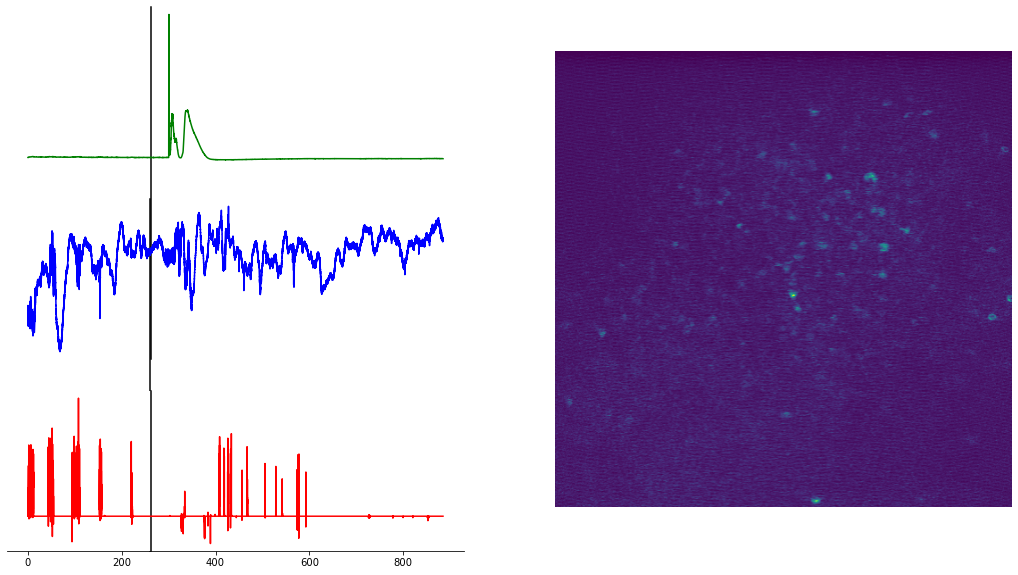

In [101]:
saveVid(5, 250)

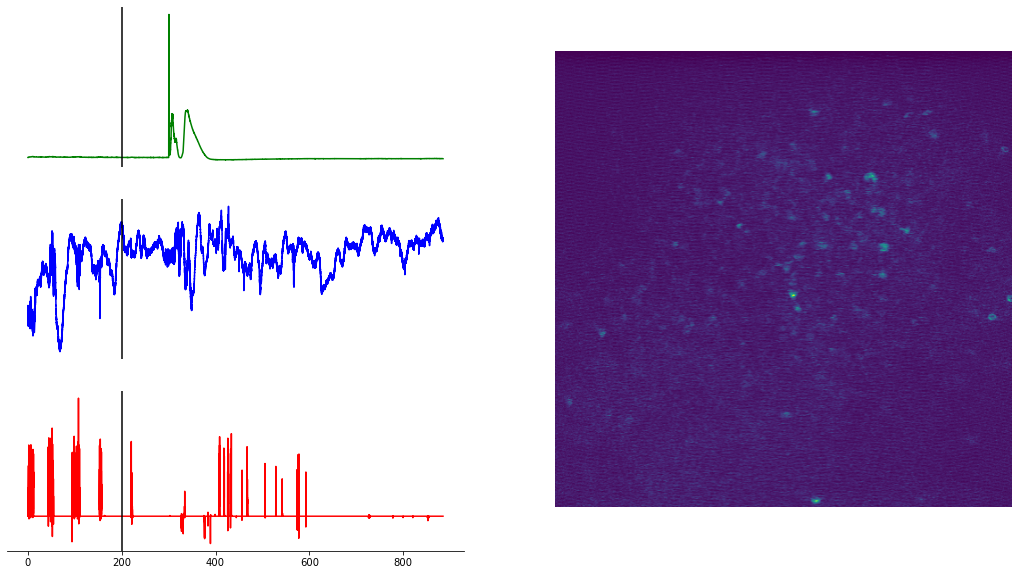

In [104]:
# Layout:
# left top figure: average luminosity
# Left middle: LFP
# left bottom: locomotion 
# Right: nd2 video playing

i_frame = 10
fontprops = fm.FontProperties(size=18)
#set up the figure

# height ratios:
# https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
# update matplotlib, then height_ratios can be directly passed to subplots()!
#fig, axs = plt.subplots(3, 2, figsize=(18,10), gridspec_kw={'height_ratios': [3, 1]}, sharey="row")
#fig, axs = plt.subplots(3, 2, figsize=(18,10), sharey="row")
#axs[0,0].axis('off')
#axs[0,1].axis('off')
#canvas_width, canvas_height = fig.canvas.get_width_height()

# 1.579 µm / pixel -> 100 µm = 63.33 pixels
"""
scalebar1 = AnchoredSizeBar(axs[0,0].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

scalebar2 = AnchoredSizeBar(axs[0,1].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)


axs[0,0].add_artist(scalebar1)
axs[0,1].add_artist(scalebar2)
"""
# Fill first frame
#fig_right = axs[0, 1].imshow(ndarr_right[i_frame], )  #cmap="Greens_r"
#ts_right = axs[1,1].plot(tstamps_right_zeroed_s, time_series_right_zeroed)
#vline_right = axs[1, 1].axvline(x=tstamps_right_zeroed_s[i_frame], color="red")

#fluor_plot = axs[0,0].plot(t_fluor, fluor)
#loco_plot = axs[1,0].plot(t, loco)
#lfp_plot = axs[2, 0].plot(t_lfp, y_lfp)

t_vertline = 200.0

fig = plt.figure(figsize=(18,10))
canvas_width, canvas_height = fig.canvas.get_width_height()
gridspec = fig.add_gridspec(3, 2)
ax_fluor = fig.add_subplot(gridspec[0,0])
ax_lfp =  fig.add_subplot(gridspec[1,0])
ax_loco = fig.add_subplot(gridspec[2,0])
ax_nikon = fig.add_subplot(gridspec[:, 1])

ax_fluor.plot(t_fluor/1000., fluor, color="green")
ax_lfp.plot(t_lfp, y_lfp, color="blue")
ax_loco.plot(t/1000., loco, color="red")

fig_nikon = ax_nikon.imshow(nik[0])

vline_fluor = ax_fluor.axvline(x=t_vertline, color="black")
vline_lfp = ax_lfp.axvline(x=t_vertline, color="black")
vline_loco = ax_loco.axvline(x=t_vertline, color="black")

ax_nikon.axis('off')
ax_fluor.axis('off')
ax_lfp.axis('off')
ax_loco.spines['left'].set_visible(False)
ax_loco.spines['right'].set_visible(False)
ax_loco.spines['top'].set_visible(False)
ax_loco.get_yaxis().set_ticks([])
#ax_fluor.get_yaxis().set_visible(False)
#ax_lfp.get_yaxis().set_visible(False)
#ax_loco.get_yaxis().set_visible(False)

#ax_fluor.get_xaxis().set_visible(False)
#ax_lfp.get_xaxis().set_visible(False)

plt.show()